# Assigment 13 | Applied Machine Learning | Paras Ahuja

Pre-process a single file using 20 frequency bins(i.e.M), and 2000 sampling
frequency (controls the number of data points), such as,
        
        x, fs = librosa.load(Path_dataset+'cat_1.wav', sr=SAMPLING_FRQ) 
        mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M) 
        librosa.display.specshow(mfccs, sr=fs, x_axis='time')

cat_1.wav file (signal) will generate 20 features, and 44 data points. Note that 2000Hz sampling frequency in fact would ignore frequencies higher than 1000Hz and we assume cats and dogs sounds are less than that range. Changing that limit to 3k, and 4k are suggested, but then this will increase the number of data points to be processed.

Display the spectrogram in your notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

PyTorch version= 1.7.0
CUDA available= False


In [2]:
import os
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import librosa
import librosa.display

print(f'librosa version= {librosa.__version__}')

librosa version= 0.8.0


In [3]:
cwd = os.getcwd()
path = cwd+'/cats_dogs/'
M = 20
K = 2
SAMPLING_FRQ = 2000

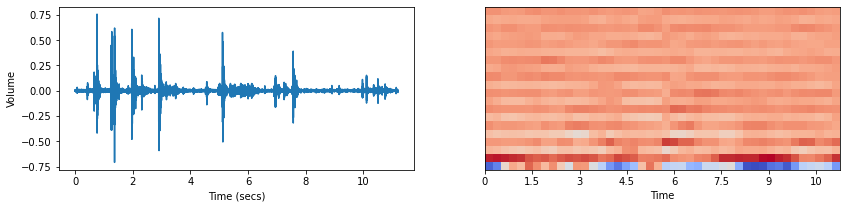

#features, #data points= (20, 44)


In [4]:
x, fs = librosa.load(path +'cat_1.wav', sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M)

plt.figure(figsize=(14, 3))
ax=plt.subplot(1, 2, 1)
ax.plot(np.arange(len(x))/fs, x)
ax.set_xlabel('Time (secs)')
ax.set_ylabel('Volume')

ax=plt.subplot(1, 2, 2)
librosa.display.specshow(mfccs, sr=fs, x_axis='time', ax=ax)
plt.show()
print(f'#features, #data points= {mfccs.shape}')

For each wav file, you will have multiple data points, as generated by the librosa.feature.mfcc. Generate the X and y matrices for supervised learning. Apply your favorite classifier and comment about your results. (Hint: Expect 80-90% 10-fold CV accuracy, and N, M = 7634, 20)

In [5]:
Flist = [f for f in os.listdir(path) if f.lower().endswith('.wav')]
print(f'#Files = {len(Flist)}')

Sxx = []

for fn in Flist:
    x, fs = librosa.load(os.path.join(path, fn), sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M)
    sxx = mfccs.T
    ct = 'cat' if 'cat' in fn else 'dog'
    Sxx += [(sxx, ct)]

#Files = 277


In [6]:
Sxx[0][1]

'cat'

In [7]:
N = sum([sxx.shape[0] for (sxx, ct) in Sxx])

X, y = np.zeros((N, M)), []

i = 0
for (sxx, ct) in Sxx:
    n2 = sxx.shape[0]
    for j in range(n2):
        X[i+j,:] = sxx[j]
    i += n2
    y += [0] * n2 if ct == 'cat' else [1] * n2
    
y = np.array(y)

print(X.shape, y.shape)

print(np.unique(y, return_counts=True))

(7634, 20) (7634,)
(array([0, 1]), array([5238, 2396]))


In [8]:
X = StandardScaler().fit_transform(X)

In [9]:
%%time

y_pred = GaussianNB().fit(X, y).predict(X)
print(f'Naive Bayes reclassification Acc= {sum(y==y_pred)/N:.2f}')

y_pred = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=None, class_weight='balanced', n_jobs=4).fit(X, y).predict(X)
print(f'Random Forest reclassification Acc= {sum(y==y_pred)/N:.2f}')

y_pred = SVC(kernel="rbf", class_weight="balanced").fit(X, y).predict(X)
print(f'RBF SVM reclassification Acc= {sum(y==y_pred)/N:.2f}')

Naive Bayes reclassification Acc= 0.78
Random Forest reclassification Acc= 0.92
RBF SVM reclassification Acc= 0.96
CPU times: user 3.72 s, sys: 81.9 ms, total: 3.8 s
Wall time: 2 s


In [10]:
%%time

def eval_classifier(clf, X, y):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
    for train_index, test_index in kf.split(X, y):
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])
        acc += [accuracy_score(y[test_index], y_pred)]
    return np.array(acc)

acc = eval_classifier(GaussianNB(), X, y)
print(f'Naive Bayes 10-fold CV Acc= {np.mean(acc):.2f}{chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(RandomForestClassifier(n_estimators=200, max_depth=7, random_state=None, class_weight='balanced', n_jobs=4), X, y)
print(f'Random Forest 10-fold CV Acc= {np.mean(acc):.2f}{chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(SVC(kernel="rbf", class_weight="balanced"), X, y)
print(f'Random Forest 10-fold CV Acc= {np.mean(acc):.2f}{chr(177)}{np.std(acc):.3f}')

Naive Bayes 10-fold CV Acc= 0.78±0.013
Random Forest 10-fold CV Acc= 0.89±0.012
Random Forest 10-fold CV Acc= 0.94±0.005
CPU times: user 28.1 s, sys: 489 ms, total: 28.6 s
Wall time: 13 s


Train a simple RNN, as given in the module Jupyter notebook, by shuffling the list of the signals (the dataset has 277) and training the network sufficiently (suggested 50 times) and compare its performance to your previous evaluation in step (2.). A prediction function is needed, such as,

    with torch.no_grad():
        hidden = rnn.init_hidden()
        sxx = torch.tensor(sxx, dtype=torch.float)
        for i in range(sxx.shape[0]):
            output, hidden = rnn.forward(sxx[i].reshape(1,rnn.n_features), hidden) 
            y = 0 if ct=='cat' else 1
            y_pred = 0 if output[0][0]>output[0][1] else 1
            
Note that the train method in the module RNN can train a single signal. An epoch can be the training of all the signals where every signal entails the hidden layer to be initialized and gradients being reset at the training start.

To answer this question techniques learned office hours are used.

In [11]:
import torch.nn as nn
import torch.optim as optim

class RNN_1(nn.Module):
    def __init__(self, n_features, n_hidden, n_output, eta=0.0005, weight=None, info=True):
        super(RNN_1, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.eta = eta
        self.info = info
        
        self.i2h = nn.Linear(n_features + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_features + n_hidden, n_output)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.criterion = nn.NLLLoss(weight=weight)
        self.optimizer = optim.Adam(self.parameters(), lr=self.eta)

    def forward(self, _x, hidden):
        combined = torch.cat((_x, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.n_hidden)
    
    def train_signal(self, _sxx, _y):
        hidden = self.init_hidden()
        self.optimizer.zero_grad()
        
        for i in range(_sxx.shape[0]):
            output, hidden = self.forward(_sxx[i].reshape(1, self.n_features), hidden)
        
        loss = self.criterion(output, _y)
        loss.backward()
        
        self.optimizer.step()
        
        return output, loss.item()

    def train(self, _Xy):
        L, totloss = len(_Xy), 0
        for i, (sxx, y) in enumerate(_Xy):
            output, loss = self.train_signal(sxx, y)
            totloss += loss
            if self.info:
                sys.stderr.write(f"\r{i+1:03d}/{L} | Loss: {loss: 6.2f} | "
                                f"Avg loss: {totloss/(i+1):6.2f} | {y.data.tolist()[0]}")
                sys.stderr.flush()
    
    def predict(self, _sxx):
        with torch.no_grad():
            hidden = self.init_hidden()
            for i in range(_sxx.shape[0]):
                output, hidden = self.forward(_sxx[i].reshape(1, self.n_features), hidden)
        return 1 if output[0][0] < output[0][1] else 0

In [12]:
from random import shuffle

def rnn_train(_rnn, _Xy_tr, nP=10):
    for _ in range(nP):
        shuffle(_Xy_tr)
        _rnn.train(_Xy_tr)
        
def rnn_test(_rnn, _X_ts):
    y_pred = []
    for sxx in _X_ts:
        y_pred += [_rnn.predict(sxx)]
    return y_pred

def reclassification(_rnn, _Xy, nP=10):
    rnn_train(_rnn, _Xy, nP=nP)
    y_pred = rnn_test(_rnn, [_[0] for _ in _Xy])
    acc = np.sum(np.array(y_pred) == np.array([int(_[1].data[0]) for _ in _Xy])) / len(_Xy)
    return acc

In [13]:
WEIGHTS = torch.tensor([113/227, 164/277])

Xy = [None]*len(Sxx)
for i in range(len(Sxx)):
    Xy[i] = (torch.tensor(Sxx[i][0], dtype=torch.float), 
            torch.tensor([0 if Sxx[i][1] == "cat" else 1], dtype=torch.int64)
            )
shuffle(Xy)

In [14]:
torch.tensor([0], dtype=torch.int64)

tensor([0])

In [15]:
Xy[0][0].shape, Xy[0][1].shape

(torch.Size([16, 20]), torch.Size([1]))

In [16]:
Xy[0][1]

tensor([1])

In [17]:
%%time

Acc = []
for i in range(10):
    rnn1 = RNN_1(M, 1, K, eta=0.001, weight=WEIGHTS, info=True)
    Acc += [reclassification(rnn1, Xy, nP=20)]
    
print(f'RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

277/277 | Loss:   1.48 | Avg loss:   0.53 | 01

RNN reclassification Acc= 0.79 ±0.056
CPU times: user 4min 13s, sys: 15.9 s, total: 4min 28s
Wall time: 4min 25s


In [18]:
%%time

Acc = []
for i in range(10):
    rnn2 = RNN_1(M, 20, K, eta=0.001, weight=WEIGHTS, info=True)
    Acc += [reclassification(rnn2, Xy, nP=20)]
    
print(f'RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

277/277 | Loss:   0.00 | Avg loss:   0.58 | 00

RNN reclassification Acc= 0.83 ±0.033
CPU times: user 4min 13s, sys: 16.2 s, total: 4min 29s
Wall time: 4min 26s


In comparison here we find that n_hidden = 20 performed better than 1. 

In [19]:
%%time

from sklearn.model_selection import KFold

Acc = []
kf = KFold(n_splits=20)

for tr_ix, ts_ix in kf.split(np.arange(len(Xy))):
    
    rnn3 = RNN_1(M, 20, K, eta=0.001, weight=WEIGHTS, info=True)
    
    rnn_train(rnn3, [Xy[_] for _ in tr_ix], nP=20)
    
    y_pred = rnn_test(rnn3, [Xy[_][0] for _ in tr_ix])
    
    Acc += [np.sum(np.array(y_pred) == np.array([int(Xy[_][1].data[0]) for _ in ts_ix])) / len(y_pred)]
    
print(f'RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

264/264 | Loss:   0.76 | Avg loss:   0.46 | 1

RNN 10-fold CV Acc= 0.00 ±0.000
CPU times: user 7min 57s, sys: 31.1 s, total: 8min 28s
Wall time: 8min 22s


In [20]:
from torch.autograd import Variable

class RNN_2(nn.Module):
    def __init__(self, n_features, n_hidden, n_output, n_hid_layers, eta=0.0005, weight=None, info=True):
        super(RNN_2, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_hid_layers = n_hid_layers
        self.eta = eta
        self.info = info
        
        self.rnn = nn.RNN(n_features, n_hidden, n_hid_layers, batch_first=False, nonlinearity="tanh")
        
        self.outlayer = nn.Linear(n_hidden, n_output)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.criterion = nn.NLLLoss(weight=weight)
        self.optimizer = optim.Adam(self.parameters(), lr=self.eta)

    def forward(self, _x, _h):
        output, hidden = self.rnn(_x, _h)
        output = self.outlayer(output[-1, :])
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_hid_layers, 1, self.n_hidden)
    
    def train_signal(self, _sxx, _y):
        hidden = self.init_hidden()
        self.optimizer.zero_grad()
        
        for i in range(_sxx.shape[0]):
            output, hidden = self.forward(_sxx[i].reshape(1, 1, self.n_features), hidden)
        
        loss = self.criterion(output, _y)
        loss.backward()
        
        self.optimizer.step()
        
        return output, loss.item()

    def train(self, _Xy):
        L, totloss = len(_Xy), 0
        for i, (sxx, y) in enumerate(_Xy):
            output, loss = self.train_signal(sxx, y)
            totloss += loss
            if self.info:
                sys.stderr.write(f"\r{i+1:03d}/{L} | Loss: {loss: 6.2f} | "
                                f"Avg loss: {totloss/(i+1):6.2f} | {y.data.tolist()[0]}")
                sys.stderr.flush()
    
    def predict(self, _sxx):
        with torch.no_grad():
            hidden = self.init_hidden()
            for i in range(_sxx.shape[0]):
                output, hidden = self.forward(_sxx[i].reshape(1, 1, self.n_features), hidden)
        return 1 if output[0][0] < output[0][1] else 0
    

rnn_2 = RNN_2(M, 20, K, 2, eta=0.001, weight=WEIGHTS)

print(rnn_2)

RNN_2(
  (rnn): RNN(20, 20, num_layers=2)
  (outlayer): Linear(in_features=20, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


In [21]:
%%time

Acc = []
for i in range(10):
    rnn3 = RNN_2(M, 20, K, 1, eta=0.002, weight=WEIGHTS, info=True)
    Acc += [reclassification(rnn3, Xy, nP=20)]
    
print(f'PyTorch 1-layer RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

277/277 | Loss:   0.00 | Avg loss:   0.26 | 0

PyTorch 1-layer RNN reclassification Acc= 0.91 ±0.010
CPU times: user 7min 31s, sys: 17.2 s, total: 7min 48s
Wall time: 7min 39s


In [22]:
%%time

Acc = []
kf = KFold(n_splits=10)

for tr_ix, ts_ix in kf.split(np.arange(len(Xy))):
    
    rnn4 = RNN_2(M, 20, K, 1, eta=0.002, weight=WEIGHTS, info=True)
    
    rnn_train(rnn4, [Xy[_] for _ in tr_ix], nP=20)
    
    y_pred = rnn_test(rnn4, [Xy[_][0] for _ in tr_ix])
    
    Acc += [np.sum(np.array(y_pred) == np.array([int(Xy[_][1].data[0]) for _ in ts_ix])) / len(y_pred)]
    
print(f'PyTorch 1-layer RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

250/250 | Loss:   0.02 | Avg loss:   0.25 | 0

PyTorch 1-layer RNN 10-fold CV Acc= 0.00 ±0.000
CPU times: user 6min 58s, sys: 15.6 s, total: 7min 13s
Wall time: 7min 5s


The RNN overall is a bit slow - at least on this computer, however research indicates that it does take a long time to converge depending on the usage. Performance varies depending on the parameters provided. For instance, in RNN_1 when n_hidden = 1, we had worse performace than when n_hidden = 20. Note that when we used pytorch accuracy was much higher!

Compare and contrast the method applied in this assignment to the image classification.

PyTorch is a Deep Learning framework is widely being used by deep learning practitioners. PyTorch is available as a Python package, which provides Tensor computations. Tensors are multidimensional arrays. These arrays are similar to numpy's ndarrays which can run on GPU as well. However, on this computer CUDA is not available, and neither is the GPU powerful enough to support operations.

We used RNN in this assignment with the help of PyTorch. In image classification we used MNIST dataset to classify, and we used neural network to classify images. Neural network is the basic idea for image classification whereas RNN and PyTorch are more of a deep learning techniques and are more robust that a simple neural network. 